# Assignment 3 - Image Segmentation using MRFs
# Loay Rashid 2018102008
## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
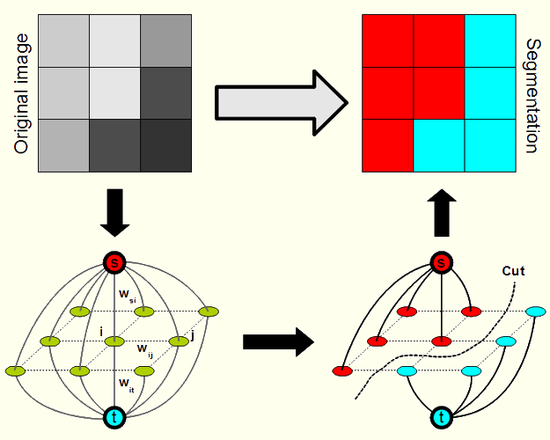

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import igraph as ig
from tqdm import tqdm 
global init_output
global strokes_output

In [3]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                self.FLAGS['rect_or_mask'] = 1
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [4]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 2}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 3}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    mask2=None
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            print("background init")
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            print("init foreground")
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
            
        elif k == ord('q'):
            if FLAGS['rect_or_mask'] <= 0:
                print("left button first boyo")
                continue
            print("strokes start")
            
            if(FLAGS['value']['val']==3):
                print("foreground")
                idx = np.where(mask == 3)
                mask2[idx] = 1
            elif(FLAGS['value']['val']==3):
                print("background")
                idx = np.where(mask == 2)
                mask2[idx] = 0
                
            mask2 = grabcut(img, mask2, rect, 3, 2)
            mask1 = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
            FLAGS['rect_or_mask'] = 0
            output = cv2.bitwise_and(img2, img2, mask = mask1)
            print("strokes done")
            strokes_output=output
        
        elif k == 13: 
#             mask=np.ones(img.shape)
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
#             print(FLAGS['RECT'])
            flag=1
            if flag:
                print("init grabcut")
                mask = np.zeros(img.shape[:2], dtype=np.uint8)
                rect = list(FLAGS['RECT'])
                print(rect)
                print("start")
                mask2 = grabcut(img, mask, rect, 5,2)
                mask1 = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
                EventObj.flags = FLAGS
                output = cv2.bitwise_and(img2, img2, mask = mask1)
                print("init grabcut done")
                init_output=output
            else:
                print(FLAGS['RECT'])
                
#             plt.imshow(output)
#             break
    fig, sub = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

    sub[0].imshow(cv2.cvtColor(init_output, cv2.COLOR_BGR2RGB))
    sub[0].axis('off')
    sub[0].set_title("Original")

    sub[1].imshow(cv2.cvtColor(strokes_output, cv2.COLOR_BGR2RGB))
    sub[1].axis('off')
    sub[1].set_title("After Strokes")

init grabcut
[8, 21, 604, 440]
start
0
1
init grabcut done
background init
init grabcut
[8, 21, 604, 440]
start
0
1
init grabcut done


UnboundLocalError: local variable 'strokes_output' referenced before assignment

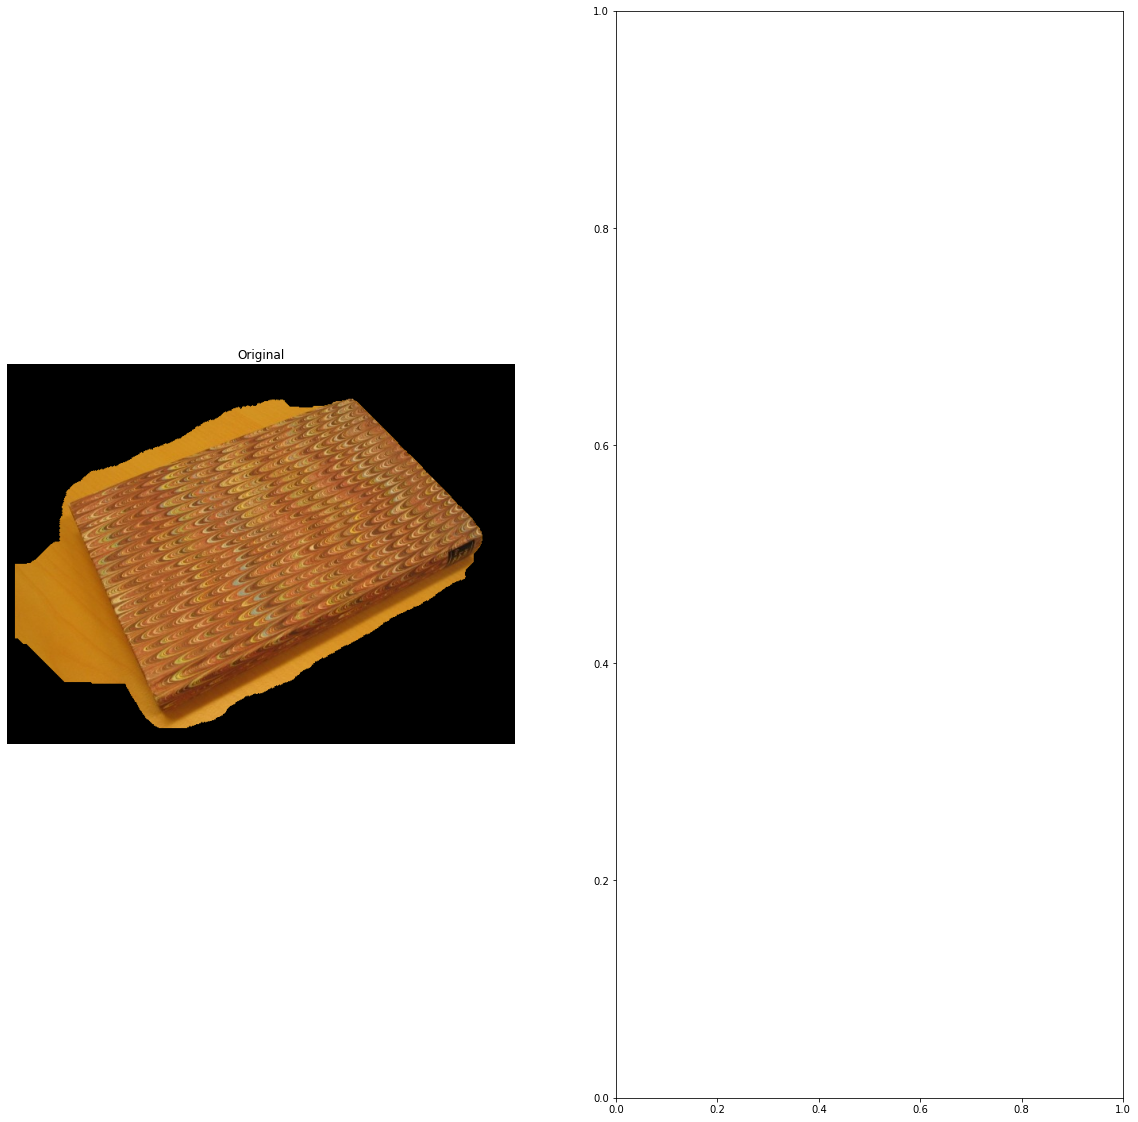

In [24]:
p_fg=3
p_bg=2
fg=1
bg=0

if __name__ == '__main__':
    filename = '../images/book.jpg'    # Path to image file
    run(filename)
    cv2.destroyAllWindows()

In [25]:
cv2.destroyAllWindows()

In [5]:
def makeEdge(points1,points2,edges):
    edges.extend(list(zip(points1, points2)))
    return edges

In [6]:
def construct_graph(img, bg_gmm, fg_gmm, mask, s, t, gamma=50):
#     print(gamma)
    r,c,_=img.shape
    edges=[]
    weights=[]
    
    prob_idx = np.where(np.logical_or(mask.reshape(-1) == p_bg, mask.reshape(-1) == p_fg))
    
    edges=makeEdge([s] * prob_idx[0].size, prob_idx[0],edges)
    edges=makeEdge([t] * prob_idx[0].size, prob_idx[0],edges)
    log_prob_bg = bg_gmm.score_samples(img.reshape(-1, 3)[prob_idx])
    log_prob_fg = fg_gmm.score_samples(img.reshape(-1, 3)[prob_idx])
    log_prob_bg = -log_prob_bg
    log_prob_fg = -log_prob_fg
    weights.extend(log_prob_bg.tolist())
    weights.extend(log_prob_fg.tolist())
    
    bgd_indexes = np.where(mask.reshape(-1) == bg)
    fgd_indexes = np.where(mask.reshape(-1) == fg)
    
    edges=makeEdge([s] * bgd_indexes[0].size, bgd_indexes[0],edges)
    edges=makeEdge([t] * bgd_indexes[0].size, bgd_indexes[0],edges)
    
    weights.extend([0] * bgd_indexes[0].size)
    weights.extend([np.inf] * bgd_indexes[0].size)
    
    edges=makeEdge([s] * fgd_indexes[0].size, fgd_indexes[0],edges)
    edges=makeEdge([t] * fgd_indexes[0].size, fgd_indexes[0],edges)
    
    weights.extend([np.inf] * fgd_indexes[0].size)
    weights.extend([0] * fgd_indexes[0].size)
    
    img_indexes = np.arange(r * c, dtype=np.uint32).reshape(r, c)
    
    mask1_1 = img_indexes[:, 1:].reshape(-1)
    mask2_1 = img_indexes[:, :-1].reshape(-1)
    edges=makeEdge(mask1_1, mask2_1,edges)
    
    mask1_2 = img_indexes[1:, :].reshape(-1)
    mask2_2 = img_indexes[:-1, :].reshape(-1)
    edges=makeEdge(mask1_2, mask2_2,edges)
    
    mask1_3 = img_indexes[1:, 1:].reshape(-1)
    mask2_3 = img_indexes[:-1, :-1].reshape(-1)
    edges=makeEdge(mask1_3, mask2_3,edges)
    
    mask1_4 = img_indexes[1:, :-1].reshape(-1)
    mask2_4 = img_indexes[:-1, 1:].reshape(-1)
    edges=makeEdge(mask1_4, mask2_4,edges)
    
    V_l, V_r, V_ul, V_ur = V(img,gamma)
    weights.extend(V_l.reshape(-1).tolist())
    weights.extend(V_r.reshape(-1).tolist())
    weights.extend(V_ul.reshape(-1).tolist())
    weights.extend(V_ur.reshape(-1).tolist())
    
    gc_graph = ig.Graph(2 + c * r)
    gc_graph.add_edges(edges)
    
    return gc_graph, weights

In [7]:
def V(img,gamma=50):
    r,c,_=img.shape
    l_diff, u_diff = img[:, 1:] - img[:, :-1], img[1:, :] - img[:-1, :]
    ul_diff, ur_diff = img[1:, 1:] - img[:-1, :-1], img[1:, :-1] - img[:-1, 1:]
    
    expectation = (np.sum(l_diff*l_diff) + np.sum(u_diff*u_diff) + np.sum(ul_diff*ul_diff) + np.sum(ur_diff*ur_diff)) / (4*r*c -3*r -3*c +2)
    
    beta=1/(2*expectation)
    
    V_l = gamma * np.exp(-beta * np.sum(l_diff*l_diff,axis=2))
    V_r = gamma * np.exp(-beta * np.sum(u_diff*u_diff,axis=2))
    V_ul = gamma * np.exp(-beta * np.sum(l_diff*l_diff,axis=2)) / np.sqrt(2)
    V_ur = gamma * np.exp(-beta * np.sum(u_diff*u_diff,axis=2)) / np.sqrt(2)
    
    return V_l, V_r, V_ul, V_ur

In [8]:
def segment_graph(img, graph, s, t, weights, mask):
    r,c,_ = img.shape
    idx = np.arange(r * c, dtype=np.uint32).reshape(r, c) #list of indexes
    idx1 = np.where(np.logical_or(mask == p_fg, mask == p_bg)) #probable points
    
    mincut = graph.st_mincut(s, t, weights)
    
    mask[idx1] = np.where(np.isin(idx[idx1], mincut.partition[0]),p_fg, p_bg)
    return mask,mincut

In [9]:
def grabcut(img, mask, rect, gmm_comps=5, iters=3, gamma=50):

    r ,c ,_ = img.shape
    s = r*c # source node
    img = img.astype(np.float64)
    t = s + 1 # sink node
    
    x0,y0=rect[1],rect[0]
    x3,y3=rect[1]+rect[3],rect[0]+rect[2]
    if np.count_nonzero(mask) == 0: #if mask is all bg
        mask[x0:x3, y0:y3] = p_fg
    
    fgd_indexes=np.where((mask==fg) + (mask==p_fg))
    bgd_indexes=np.where((mask==bg) + (mask==p_bg))
    
    bg_gmm = GaussianMixture(n_components = gmm_comps)
    fg_gmm = GaussianMixture(n_components = gmm_comps)
    comp_idxs = np.zeros((r, c), dtype=np.uint32)

#     for i in tqdm(range(iters)):   
    for i in range(iters):
        print(i)
        bg_gmm.fit(img[bgd_indexes])
        fg_gmm.fit(img[fgd_indexes])
        
        gc_graph, weights = construct_graph(img, bg_gmm, fg_gmm, mask, s, t, gamma)
        
        mask, mincut = segment_graph(img, gc_graph, s, t, weights, mask)
        
        fgd_indexes=np.where((mask==fg) + (mask==p_fg))
        bgd_indexes=np.where((mask==bg) + (mask==p_bg))
#     cv2.imshow('mask',80*mask)
    return mask

# Example of Stroke Implementation

init grabcut
[46, 44, 561, 414]
start
0
1
init grabcut done
background init
strokes start
0
1
strokes done


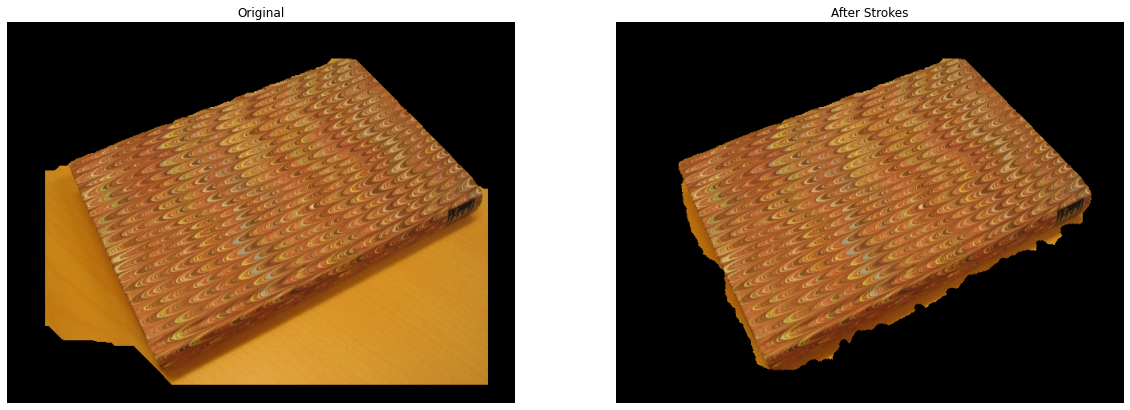

In [197]:
p_fg=3
p_bg=2
fg=1
bg=0

if __name__ == '__main__':
    filename = '../images/book.jpg'    # Path to image file
    run(filename)
    cv2.destroyAllWindows()

init grabcut
[132, 100, 183, 442]
start
0
1
init grabcut done
init foreground
strokes start
foreground
0
1
strokes done
init foreground
strokes start
foreground
0
1
strokes done


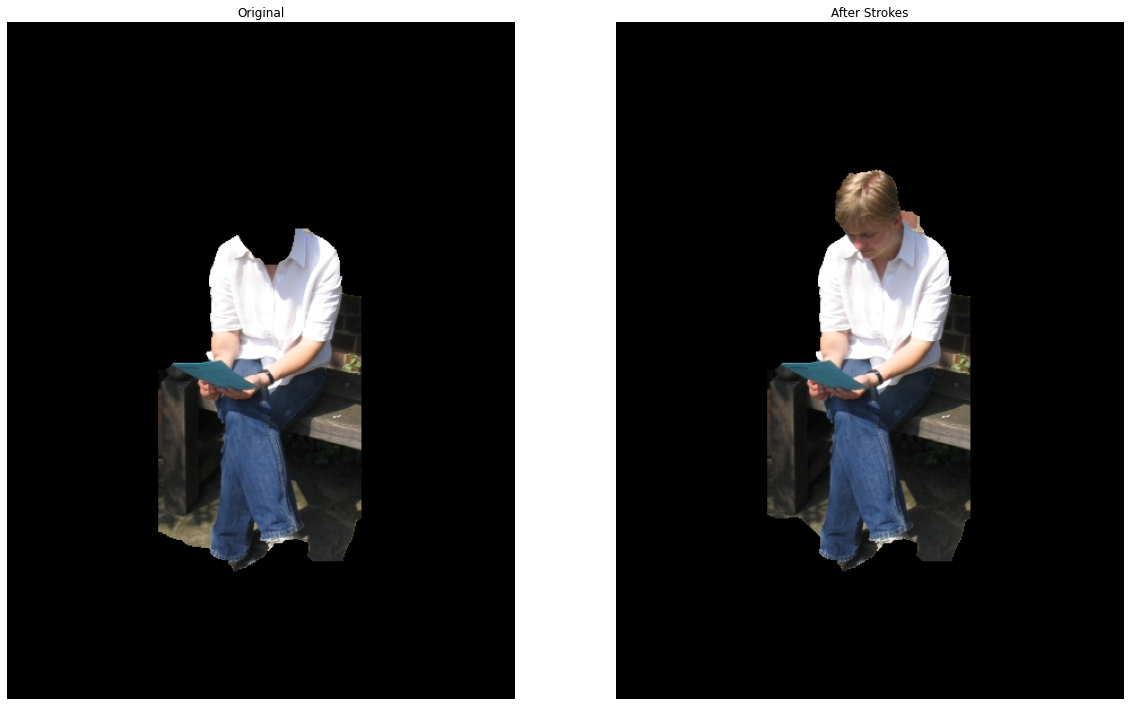

In [198]:
if __name__ == '__main__':
    filename = '../images/person6.jpg'    # Path to image file
    run(filename)
    cv2.destroyAllWindows()

init grabcut
[21, 25, 582, 434]
start
0
1
init grabcut done
background init
strokes start
0
1
strokes done


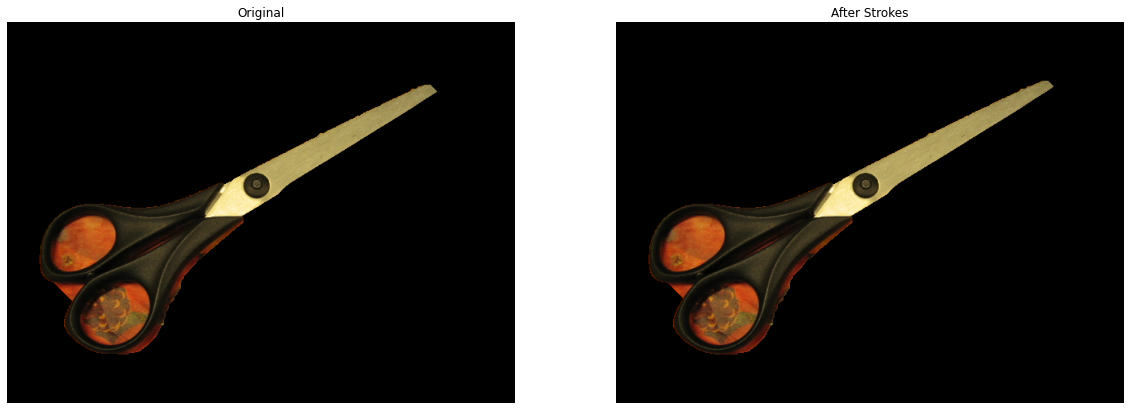

In [199]:
if __name__ == '__main__':
    filename = '../images/scissors.jpg'    # Path to image file
    run(filename)
    cv2.destroyAllWindows()

# Comparison on Number of Iterations

Higher the number of iterations, more accurate the segmentation will be as the GMM has more iterations to fit the data. The results show this.

In [225]:
def plotting_iters(img,rect,gmm_comps,iters):
    p_fg=3
    p_bg=2
    fg=1
    bg=0
    imgc = img.copy()
    
    fig, sub = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

    sub[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    sub[0,0].axis('off')
    sub[0,0].set_title("Original")
    print('0')
    
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2=grabcut(img,mask,rect, gmm_comps, 1)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[0,1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[0,1].axis('off')
    sub[0,1].set_title("1 iteration")
    print('1')

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2 = grabcut(img,mask,rect, gmm_comps, 3)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[1,0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[1,0].axis('off')
    sub[1,0].set_title("3 iterations")
    print('3')

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2 = grabcut(img,mask,rect, gmm_comps, 5)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[1,1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[1,1].axis('off')
    sub[1,1].set_title("5 iterations")
    print('5')


0
0
1
0
1
2
3
0
1
2
3
4
5


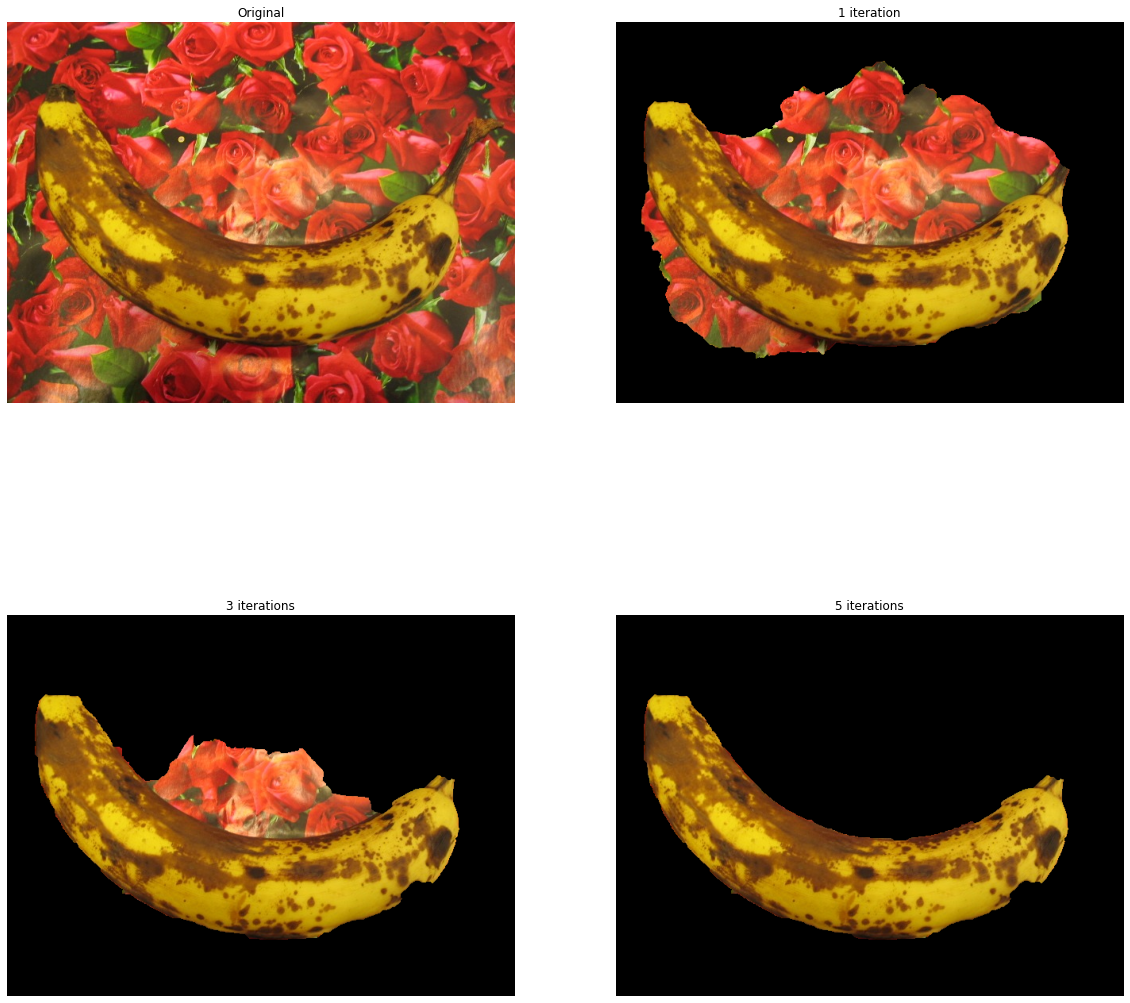

In [90]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/banana3.jpg")
rect=[32, 47, 585, 390]
plotting_iters(img, rect, 5,5)

0
1
3
5


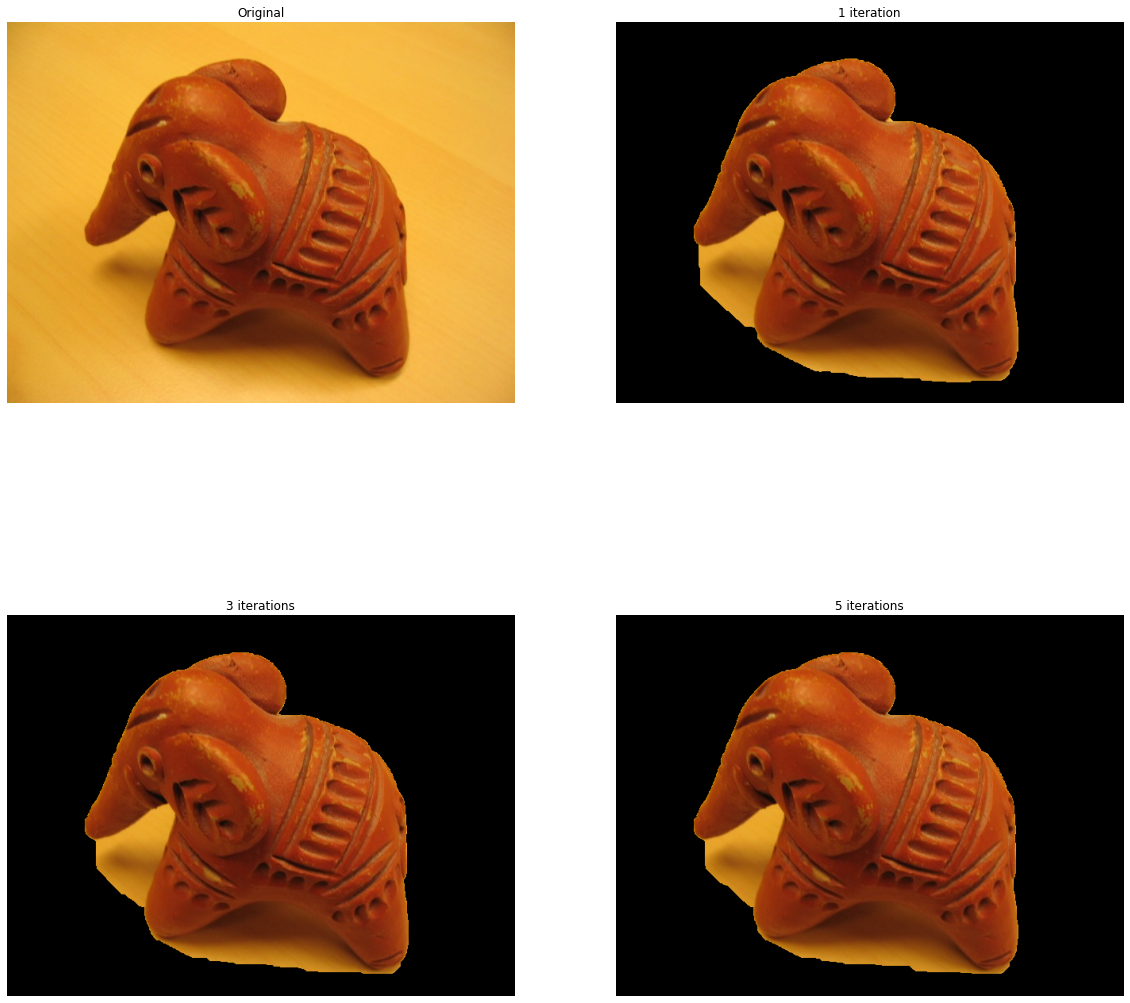

In [68]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/elefant.jpg")
# rect=[25, 150, 575, 300]
rect=[61, 35, 472, 419]
plotting_iters(img, rect, 5,5)

0
0
1
0
1
2
3
0
1
2
3
4
5


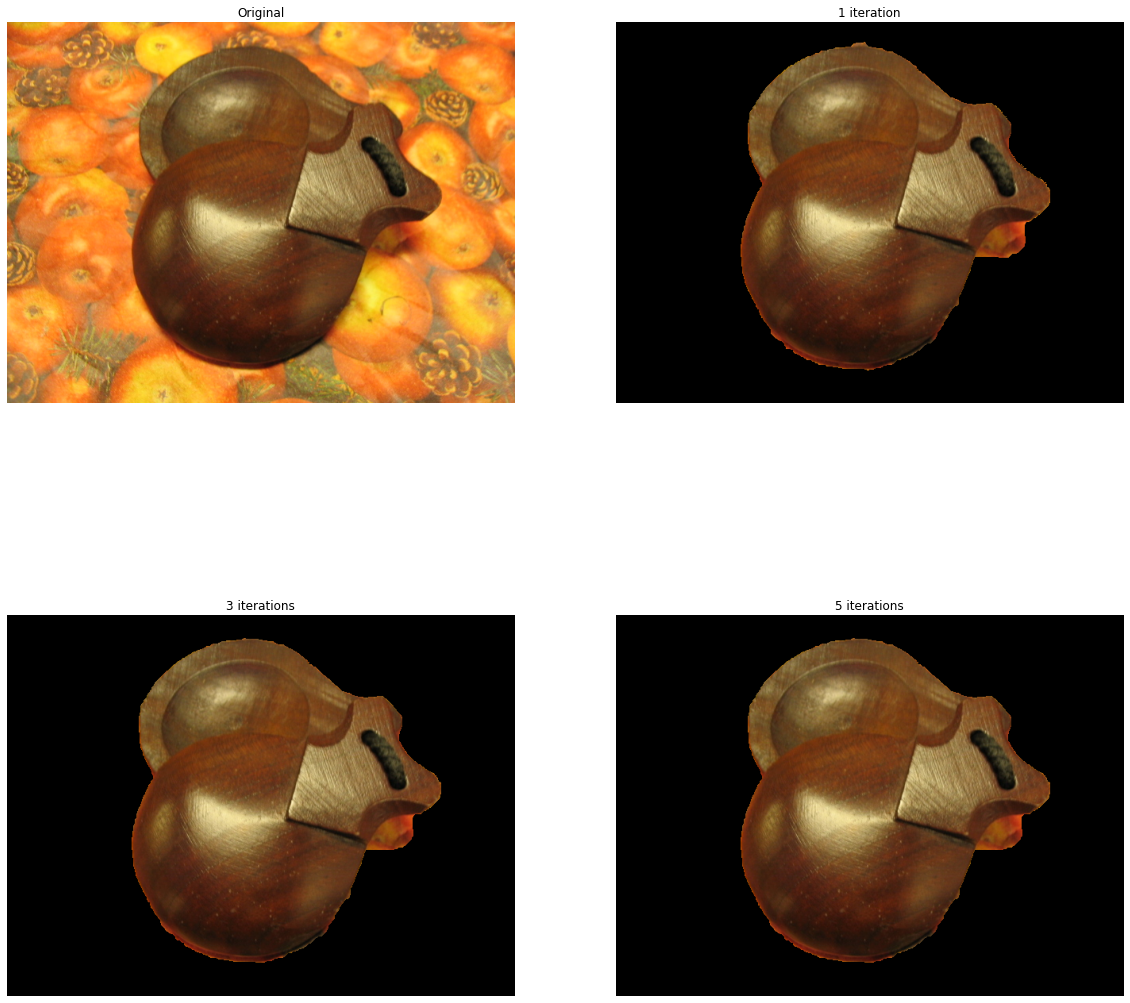

In [226]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/music.jpg")
# rect=[25, 150, 575, 300]
rect=[154, 9, 418, 446]
plotting_iters(img, rect, 5,5)

# Comparison WRT Gamma

Increasing the gamma values makes the segmentation smoother.

In [178]:
def plotting_gamma(img,rect,gmm_comps,iters):
    p_fg=3
    p_bg=2
    fg=1
    bg=0

    imgc = img.copy()

    fig, sub = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

    sub[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    sub[0,0].axis('off')
    sub[0,0].set_title("Original")
    print('0')
    
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2 = grabcut(img,mask,rect, 3, 2, 10)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[0,1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[0,1].axis('off')
    sub[0,1].set_title("Gamma=10")
    print('1')

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2 = grabcut(img,mask,rect, 3, 2, 50)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[1,0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[1,0].axis('off')
    sub[1,0].set_title("Gamma=50")
    print('3')

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2= grabcut(img,mask,rect, 3, 2, 100)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[1,1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[1,1].axis('off')
    sub[1,1].set_title("Gamma=500")
    print('5')

0
10
10
1
50
50
3
100
100
5


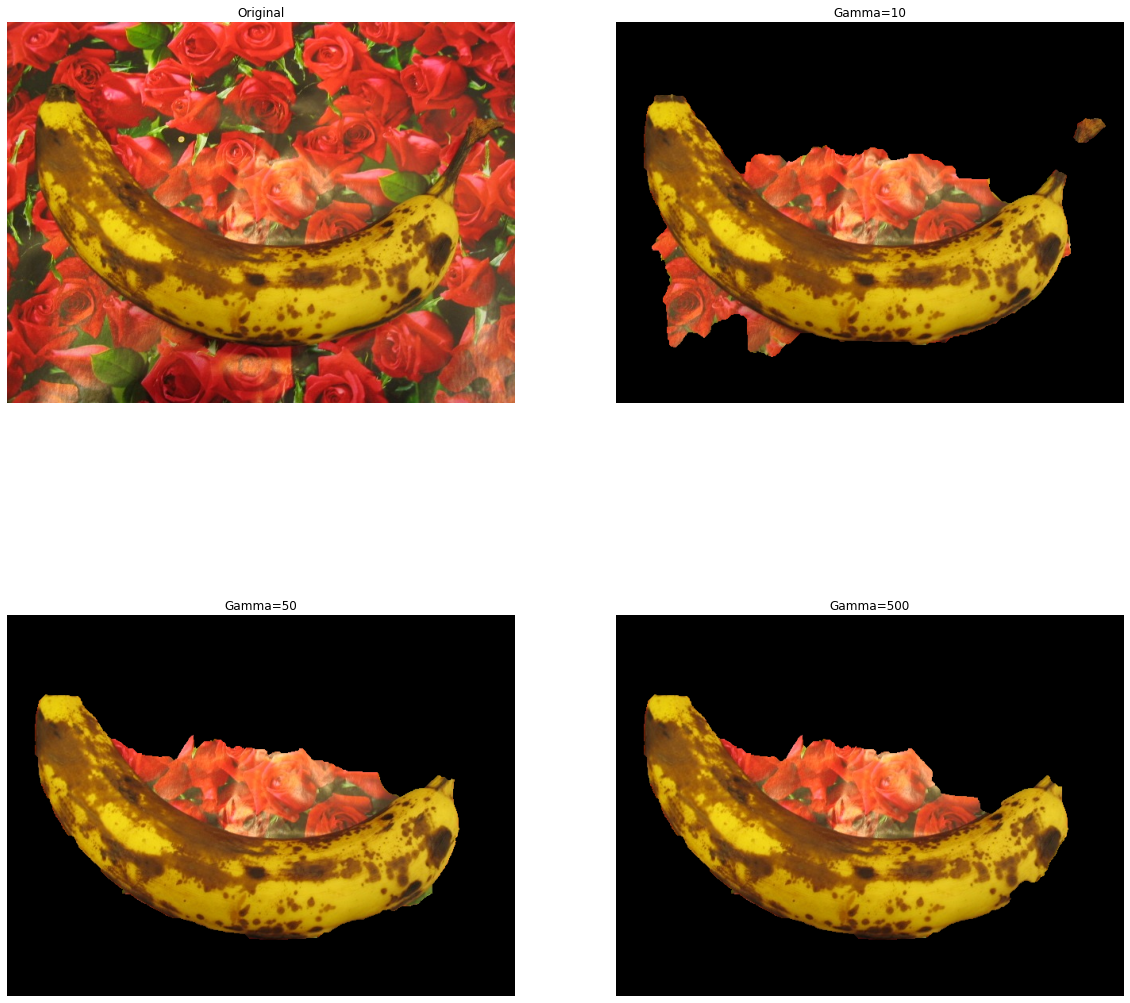

In [108]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/banana3.jpg")
rect=[32, 47, 585, 390]
plotting_gamma(img, rect, 7,5)

0
1
3
5


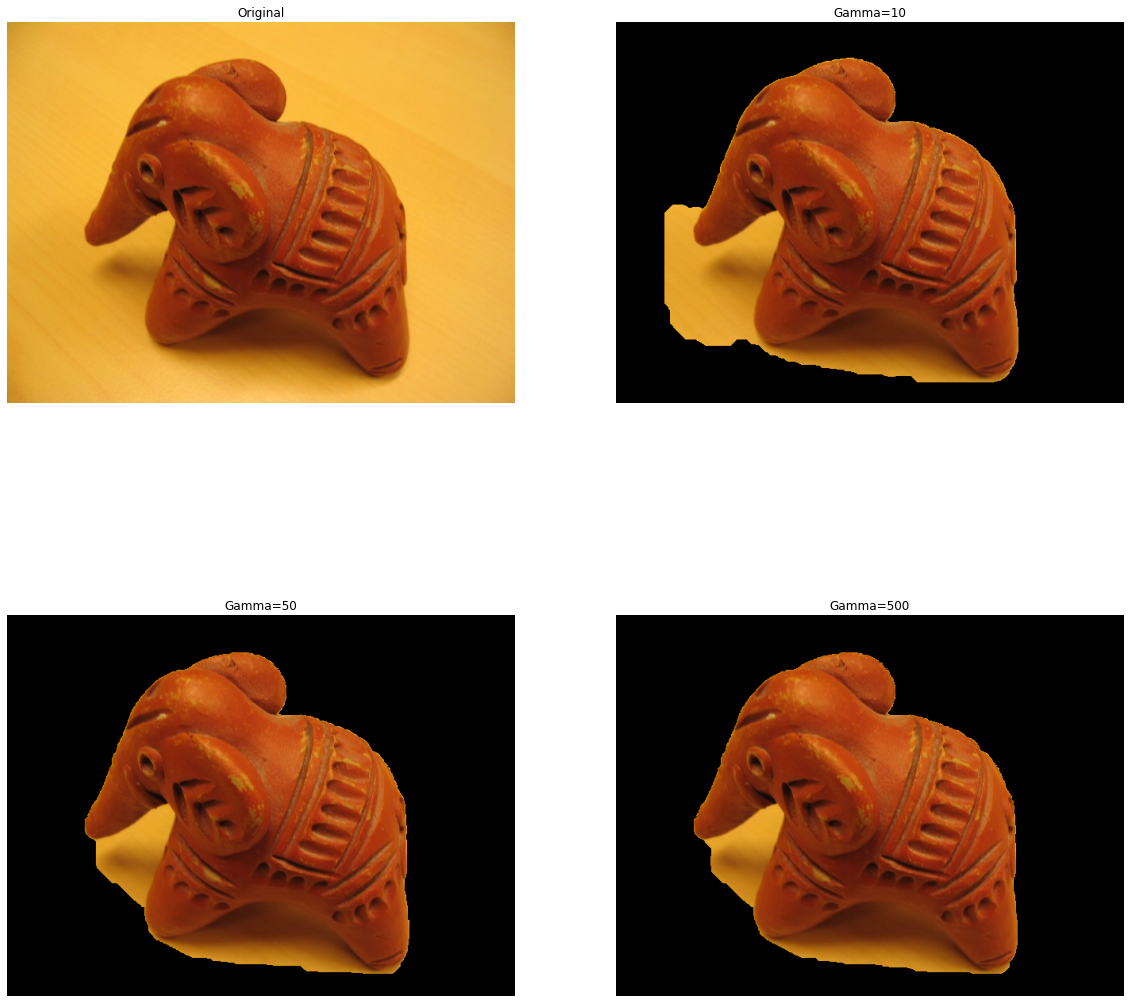

In [110]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/elefant.jpg")
# rect=[25, 150, 575, 300]
rect=[61, 35, 472, 419]
plotting_gamma(img, rect, 7,5)

0
1
3
5


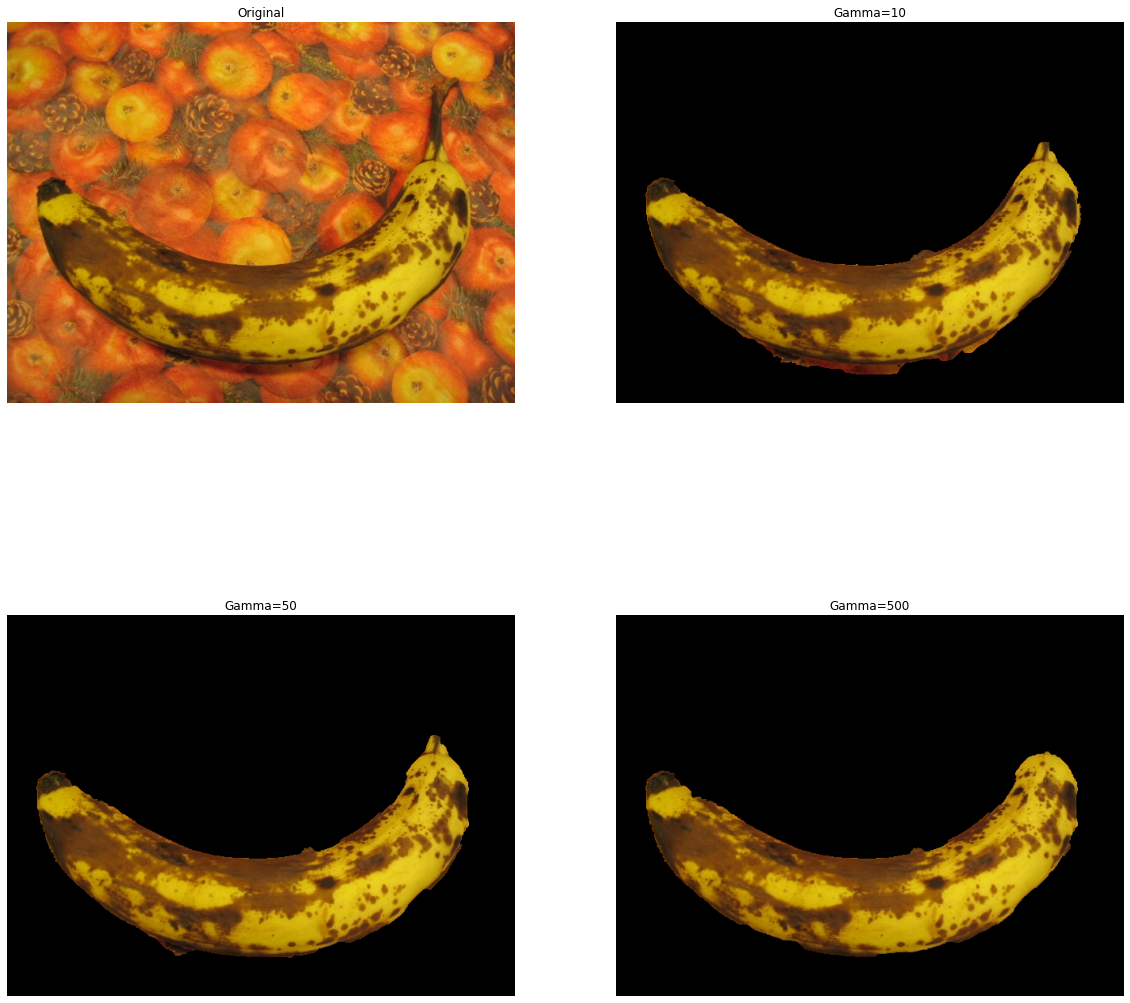

In [111]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/banana2.jpg")
rect=[25, 150, 575, 300]
plotting_gamma(img, rect, 7,5)

# Comparison on Tight vs Loose BBox

Having a tighter BBox gives better outputs

In [136]:
def plotting_bbox(img,rect1,rect2,gmm_comps,iters):
    p_fg=3
    p_bg=2
    fg=1
    bg=0

    imgc = img.copy()

    fig, sub = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    print('0')    
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2 = grabcut(img,mask,rect1, gmm_comps, iters)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[0].axis('off')
    sub[0].set_title("Tight")
    print('1')
    
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2 = grabcut(img,mask,rect2, gmm_comps, iters)
    mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
    imgc = img.copy()
    output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
    sub[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    sub[1].axis('off')
    sub[1].set_title("Loose")
    print('2')

0
1
2


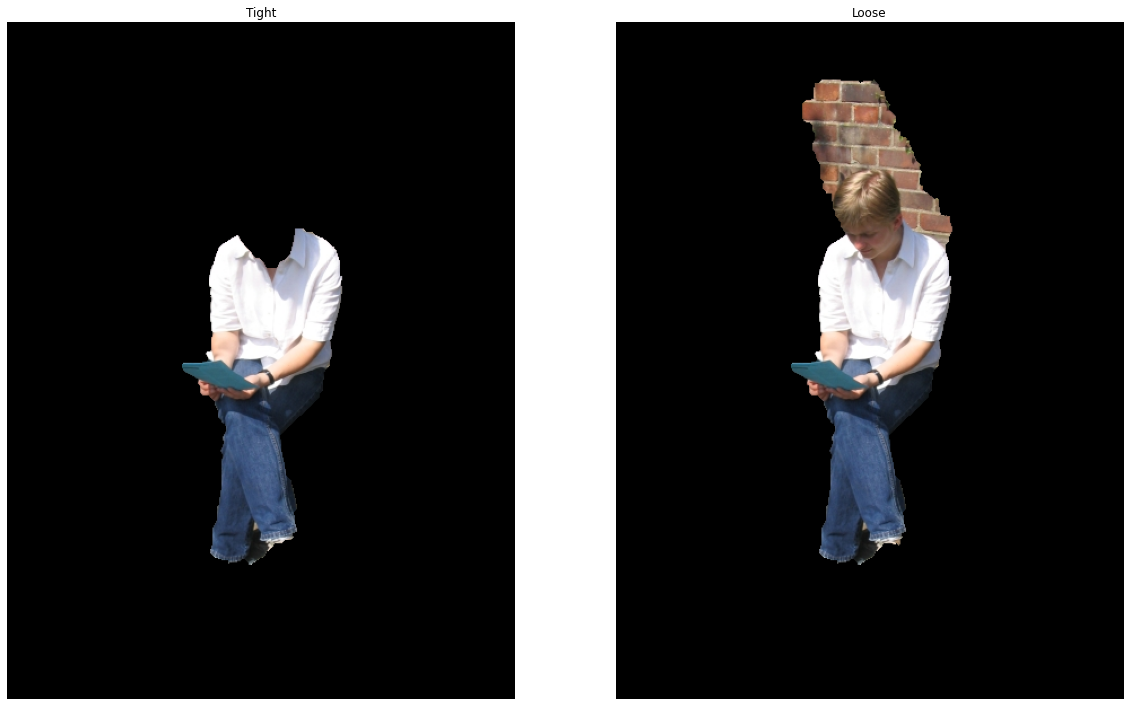

In [133]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/person6.jpg")
# rect1=[167, 132, 133, 389] #tight
rect1=[154, 129, 149, 391] #tight

rect2=[43, 42, 330, 532] #loose
plotting_bbox(img, rect1, rect2, 3,3)

0
0
1
2
1
0
1
2
2


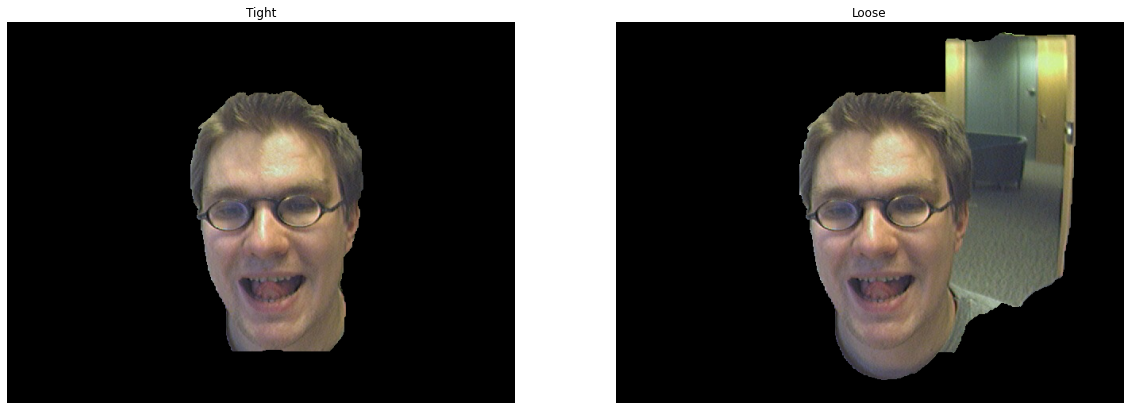

In [205]:
rect2=[8, 13, 617, 453] # loose
rect1=[216, 78, 241, 337] # tight
img=cv2.imread("../images/person8.jpg")
plotting_bbox(img, rect1, rect2, 3,3)

0
1


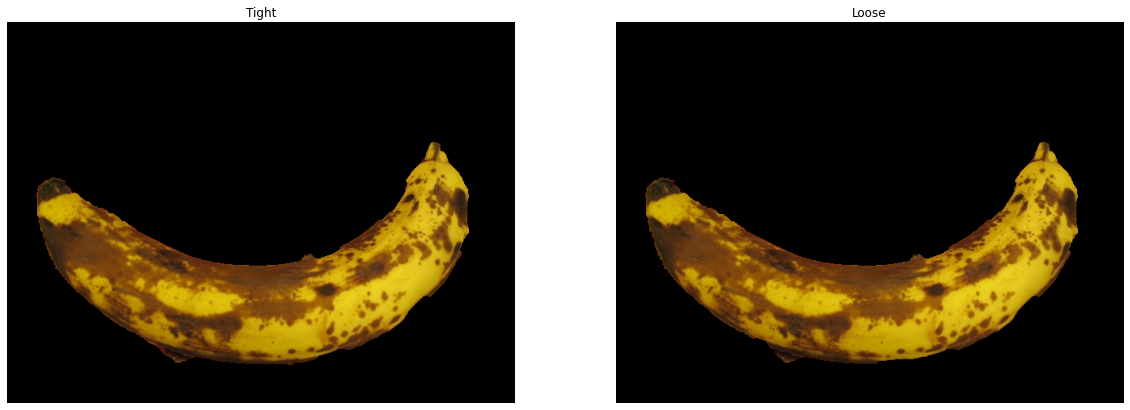

In [121]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/banana2.jpg")
rect1=[25, 150, 575, 300] # tight
rect2=[6, 8, 611, 464] # loose
plotting_bbox(img, rect1, rect2, 3,3)

0


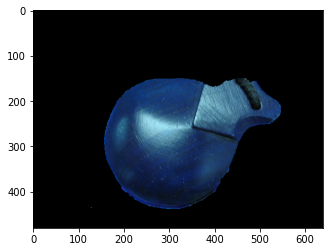

In [222]:
p_fg=3
p_bg=2
fg=1
bg=0
img=cv2.imread("../images/music.jpg")
rect1=[25, 150, 575, 300] # tight

mask = np.zeros(img.shape[:2], dtype=np.uint8)
mask2 = grabcut(img,mask,rect1, 3, 1)
mask = np.where((mask2 == 1) + (mask2 == 3), 255, 0).astype('uint8')
imgc = img.copy()
output = cv2.bitwise_and(imgc, imgc, mask=mask.astype('uint8'))
plt.imshow(output)
# rect2=[6, 8, 611, 464] # loose
# plotting_bbox(img, rect1, rect2, 3,3)